# Spam Email detection: Feature Engineering
Prepared By Deepa Francis<br>
For BrainStation<br>
On July 31, 2023

# Table of Contents<br>

[1. Features](#ft) <br>
[2. Feature 1: email_to](#et) <br>
- [2.1. xxx](#et1) <br>

[3. Feature 2: email_from](#ef) <br>
- [3.1. xxx](#ef1) <br>

[4. Feature 3: subject](#sub) <br>
[5. Feature 4: message](#msg) <br>

In [32]:
# import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 

# display all columns in dataframe
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# Load the sampled data
sampled_data = pd.read_csv('sampled_data.csv') 

In [34]:
# Instantiate sample features and target
X_sample = sampled_data.drop(columns="label")
y_sample = sampled_data["label"]

In [35]:
# Check the shapes of feature and target
print('The shape of Features: ', X_sample.shape)
print('The shape of Target: ', y_sample.shape)

The shape of Features:  (40000, 4)
The shape of Target:  (40000,)


In [36]:
# Check the features
X_sample.head()

,subject,email_to,email_from,message
0,Re: [sugar] new Sugar dependency: libtelepathy...,sugar@laptop.org,Dafydd Harries <daf@rhydd.org>,Content-Type: text/plain; charset=us-ascii\nCo...
1,Rev 307: enable TCP keepalives in http://samba...,samba-cvs@samba.org,tridge@samba.org,----------------------------------------------...
2,[perl #43105] [PATCH] function mmd.c::mmd_expa...,"""OtherRecipients of perl Ticket #43105"": ;","""Bernhard Schmalhofer via RT"" <parrotbug-follo...",> > What happens when NULL is not a consective...
3,Re: [R] Appropriate regression model for categ...,R-help@stat.math.ethz.ch,Robert A LaBudde <ral@lcfltd.com>,"At 01:45 PM 6/12/2007, Tirtha wrote:\n>Dear us..."
4,TONIGHT ON SHOWBIZ TONIGHT - CNN HEADLINE PRIM...,ktwarwic@flax9.UWATERLOO.CA,Showbiz Tonight <showbiz@mail.cnn.com>,"Content-type: text/plain; charset=""US-ASCII"" T..."


There are four features. All of them are text data. Lets take look into them one by one

<a id = "et"></a>
## 2. Feature 1: email_to

Since the goal of the machine learning task is spam detection, the recipient email address might not provide relevant information for the specific task. Dropping the "email_to" feature allows the model to focus solely on the nature of incoming emails.<br>

If the dataset contains a large number of unique email addresses in the "email_to" feature, including it as a categorical feature could lead to high dimensionality. High-dimensional feature spaces can pose challenges in terms of computational complexity, memory usage, and model interpretability. <br>

By dropping the "email_to" feature, the dimensionality of the feature space is reduced, simplifying the machine learning process.

In [37]:
# Drop the 'email_to' column
X_sample.drop('email_to', axis=1, inplace=True)
# Confirm the changes
X_sample.head()

,subject,email_from,message
0,Re: [sugar] new Sugar dependency: libtelepathy...,Dafydd Harries <daf@rhydd.org>,Content-Type: text/plain; charset=us-ascii\nCo...
1,Rev 307: enable TCP keepalives in http://samba...,tridge@samba.org,----------------------------------------------...
2,[perl #43105] [PATCH] function mmd.c::mmd_expa...,"""Bernhard Schmalhofer via RT"" <parrotbug-follo...",> > What happens when NULL is not a consective...
3,Re: [R] Appropriate regression model for categ...,Robert A LaBudde <ral@lcfltd.com>,"At 01:45 PM 6/12/2007, Tirtha wrote:\n>Dear us..."
4,TONIGHT ON SHOWBIZ TONIGHT - CNN HEADLINE PRIM...,Showbiz Tonight <showbiz@mail.cnn.com>,"Content-type: text/plain; charset=""US-ASCII"" T..."


<a id = "ef"></a>
## 3. Feature 2: email_from

email_from feature has the email address of the sender. It has a pattern. So we can extract displayname, username, email host and domain extension from this.

In [38]:
# Check unique values of email_from
X_sample['email_from'].value_counts().count()

22619

We are using pandas string method called extract. It is used to extract substrings from the "email_from" column that match the specified regular expression pattern.

In [39]:
# clean email_from
df_email_from = pd.DataFrame()
df_email_from["from_display_name"] = X_sample["email_from"].str.extract(r"^([^<]+)")
df_email_from["from_username"] = X_sample["email_from"].str.extract(r"<(.*?)@")
df_email_from["from_host"] = X_sample["email_from"].str.extract(r"@(\w+)")
df_email_from["from_domain"] = X_sample["email_from"].str.extract(r"@[\w.]+\.(\w+)")

# Removing double quotes (") and commas (,) from "display_name" column
df_email_from["from_display_name"] = df_email_from["from_display_name"].str.replace(r'[",]', '')

# View the extracted results
df_email_from.head()

,from_display_name,from_username,from_host,from_domain
0,Dafydd Harries,daf,rhydd,org
1,tridge@samba.org,NaN,samba,org
2,"""Bernhard Schmalhofer via RT""",parrotbug-followup,parrotcode,org
3,Robert A LaBudde,ral,lcfltd,com
4,Showbiz Tonight,showbiz,mail,com


Now we need to clean this dataframe before making it into features

In [40]:
# Number of missing values in the email_from dataframe
print(f"Number of missing values: {df_email_from.isna().sum().sum()}")

Number of missing values: 5336


In [41]:
# Check column wise count of missing values
df_email_from.isna().sum()

from_display_name     753
from_username        2938
from_host               4
from_domain          1641
dtype: int64

Replace null values and missing values with 'Unkown' string, since we don't have this information available.

In [42]:
df_email_from['from_display_name'] = df_email_from['from_display_name'].replace([np.nan, ''], 'Unknown')
df_email_from['from_username'] = df_email_from['from_username'].replace([np.nan, ''], 'Unknown')
df_email_from['from_host'] = df_email_from['from_host'].replace([np.nan, ''], 'Unknown')
df_email_from['from_domain'] = df_email_from['from_domain'].replace([np.nan, ''], 'Unknown')

# Check column wise count of missing values
df_email_from.isna().sum()

from_display_name    0
from_username        0
from_host            0
from_domain          0
dtype: int64

Lets closely examine each of the extracted features.

**Email Host: from_host**

In [43]:
# Unique email hosts
print('There are', df_email_from['from_host'].value_counts().count(), ' email hosts')

There are 13158  email hosts


Lets see which are the top 20 email_hosts

from_host
samba         2851
gmail         2692
yahoo         1028
mail           939
broadcast      637
cbsig          549
messaging      336
stats          335
hotmail        320
parrotcode     312
foxnews        223
pelmorex       205
debian         197
gmx            183
flax9          169
ebs            168
verizon        161
keionline      156
calcium        152
wgz            150
Name: count, dtype: int64


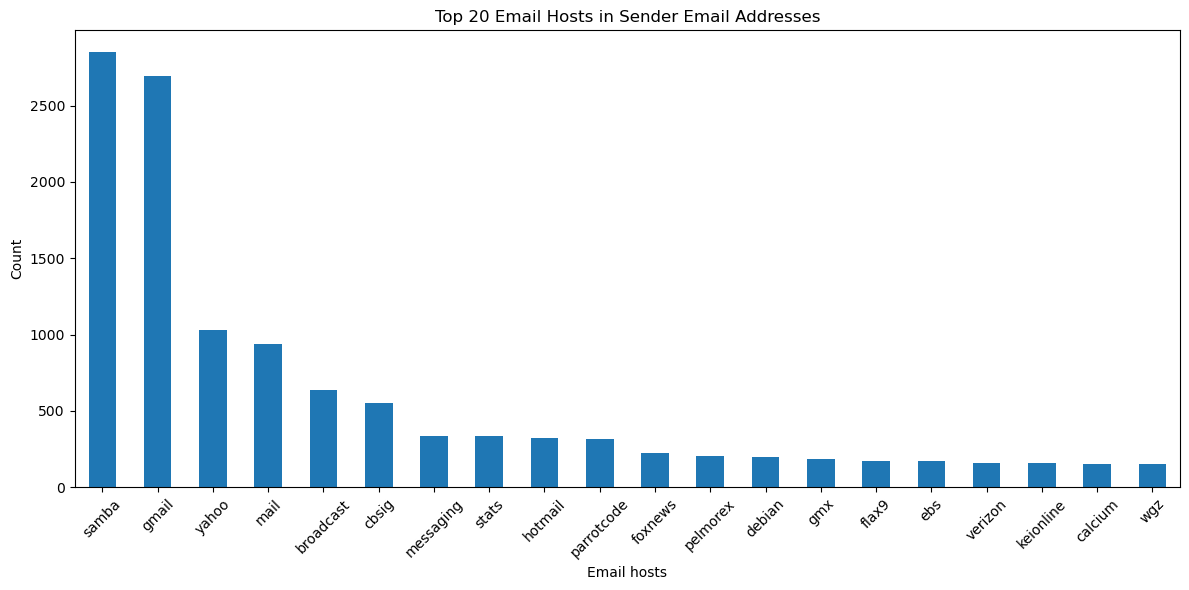

In [44]:
top_20_counts = df_email_from['from_host'].value_counts().head(20)
print(top_20_counts)

# Plotting the top 20 value counts as a bar plot
plt.figure(figsize=(12, 6))
top_20_counts.plot(kind='bar')
plt.xlabel('Email hosts')
plt.ylabel('Count')
plt.title('Top 20 Email Hosts in Sender Email Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the top 20 email hosts, lets keep the popular ones and club the rest of them together as 'Others'.

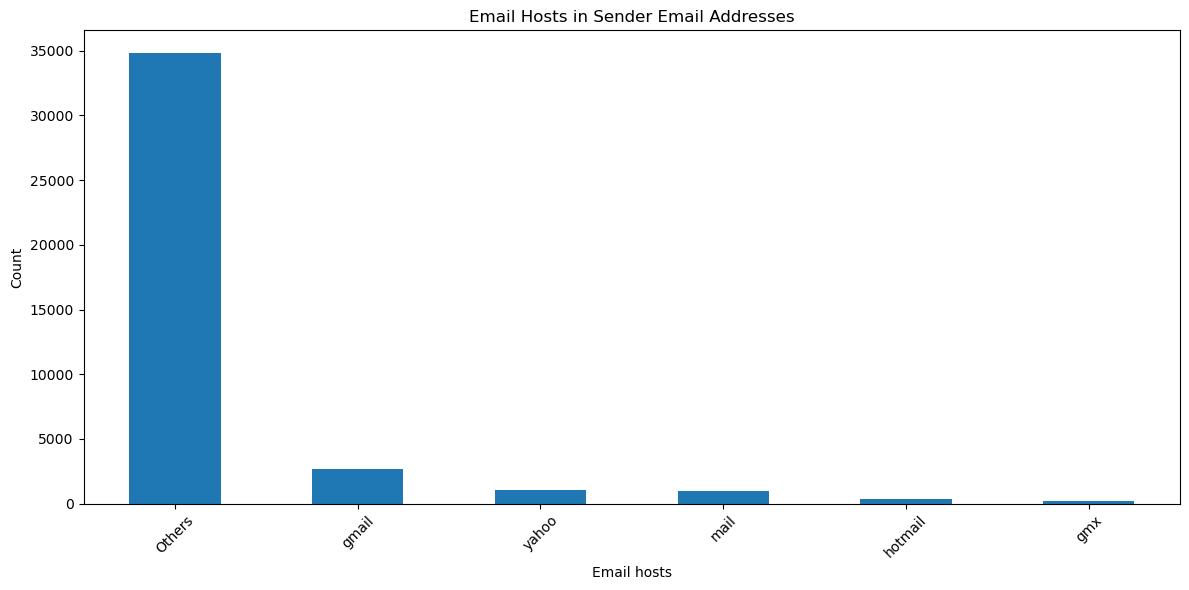

In [45]:
# List of email hosts to keep
popular_email_hosts = ['gmail', 'yahoo', 'mail', 'hotmail', 'gmx']

# Map the 'from_host' column to 'Others' using lambda function and .apply
df_email_from['from_host'] = df_email_from['from_host'].apply(lambda host: host if host in popular_email_hosts else 'Others')

# Display new value counts for Sender email host
email_host_counts = df_email_from['from_host'].value_counts()

# Plotting the top 20 value counts as a bar plot
plt.figure(figsize=(12, 6))
email_host_counts.plot(kind='bar')
plt.xlabel('Email hosts')
plt.ylabel('Count')
plt.title('Email Hosts in Sender Email Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

View the top email host categories removing 'Others'

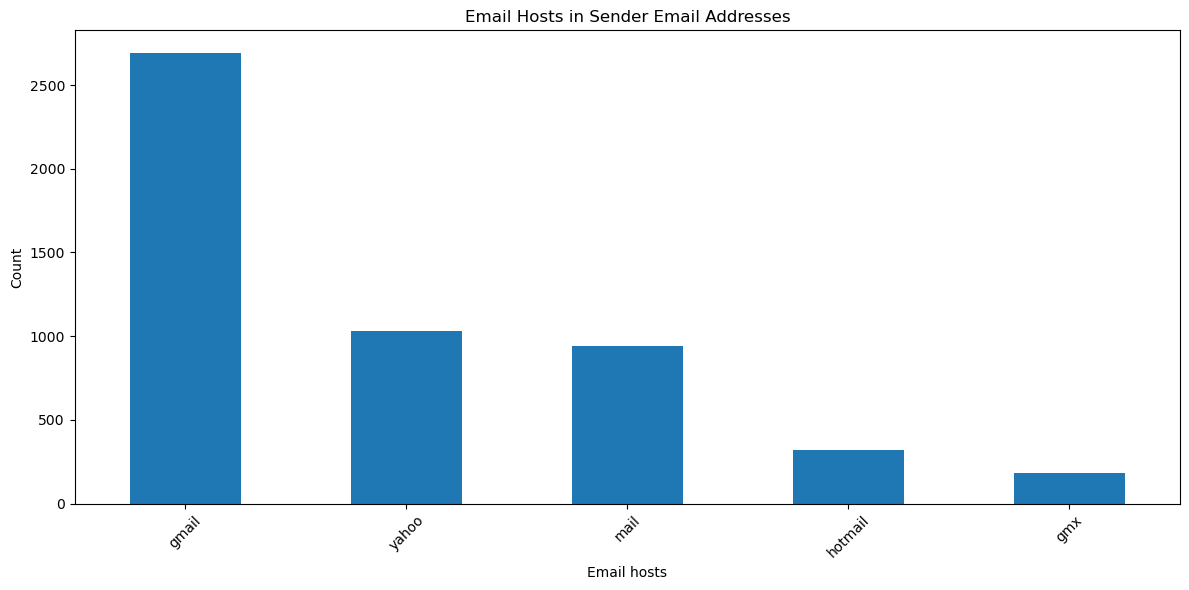

In [46]:
# Filter out the 'Others' category from the value counts
top_email_hosts = email_host_counts.drop('Others')

# Plotting the top 20 value counts as a bar plot
plt.figure(figsize=(12, 6))
top_email_hosts[:20].plot(kind='bar')
plt.xlabel('Email hosts')
plt.ylabel('Count')
plt.title('Email Hosts in Sender Email Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [54]:
# Check the new feature classes
df_email_from.sample(5)

,from_display_name,from_username,from_host,from_domain
15487,Stephen Tucker,brown_emu,yahoo,com
20348,"""Nigel""",zzzedurvirf,Others,net
5781,Gaijin,gaijin,Others,net
29877,Cary Henson,ffqnandins,Others,Unknown
28258,"""Amir Lopez""",ugoline.com,Others,com
